In [1]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
from scipy.signal.windows import tukey
from matplotlib.gridspec import GridSpec
import pywt

### Define some functions

In [2]:
def load_data(filepath):
    """
    Load the dataset from a NetCDF file.

    Parameters:
    filepath (str): Path to the NetCDF file.

    Returns:
    xr.Dataset: The loaded dataset.
    """
    
    return xr.open_dataset(filepath+'modified_dataset.nc')

def normalize_chunks(dset):
    """
    Normalize the 'chunk' variable in the dataset by its maximum value along the 'time' dimension.

    Parameters:
    dset (xr.Dataset): The input dataset containing 'chunk' variable.

    Returns:
    xr.DataArray: The normalized 'chunk' variable.
    """
    norm_value = dset['chunk'].max(dim='time')
    dset['chunk'] /= norm_value

    return dset['chunk']

def define_wavelet_transform(fs, bins_0, bins_1):
    """
    Define the wavelet transform parameters including mother wavelet, frequencies, and scales.

    Parameters:
    fs (int): Sampling rate.
    bins_0 (int): Number of bins for the first wavelet transform.
    bins_1 (int): Number of bins for the second wavelet transform.

    Returns:
    dict: Dictionary containing wavelet parameters for both transforms.
    """
    mother_wavelet_0 = 'cmor1.0-1.0'
    frequencies_0 = np.geomspace(5, 90, num=bins_0) / fs
    scales_0 = pywt.frequency2scale(mother_wavelet_0, frequencies_0)

    mother_wavelet_1 = 'cmor2.0-1.0'
    frequencies_1 = np.geomspace(0.5, 80, num=bins_1) / fs
    scales_1 = pywt.frequency2scale(mother_wavelet_1, frequencies_1)

    return {
        'mother_wavelet_0': mother_wavelet_0,
        'scales_0': scales_0,
        'frequencies_0': frequencies_0 * fs,
        'mother_wavelet_1': mother_wavelet_1,
        'scales_1': scales_1,
        'frequencies_1': frequencies_1 * fs
    }

In [32]:
# global variables
PATH2DATA = '/home/steinre/work/SeismicLife/SeisSavanna/decoding_footsteps/data/'
FS = 200  # Sampling rate
BINS_0, BINS_1 = 64, 64
index_comp = 0
indices = [57573, 21798, 57421, 12559, 38844, 2474, 10983, 12671] # indices of the modified dataset

In [37]:
# load and normalize data
dset = load_data(PATH2DATA)
#waveforms = normalize_chunks(dset)
waveforms = dset['chunk'][indices,index_comp]
species_labels = dset['species'][indices].to_numpy()
stations_labels = dset['station'][indices].to_numpy()
distances_labels = dset['distance'][indices].to_numpy()

# Define wavelet transform parameters
wavelet_params = define_wavelet_transform(FS, BINS_0, BINS_1)

In [38]:
waveforms.shape

(8, 2048)

In [39]:
n_obs, n_pts = waveforms.shape
alpha = 0.1
scat_coef_1 = np.zeros((n_obs, BINS_0, BINS_1))

tukey_window = tukey(n_pts, alpha=alpha)

waveforms_tapered = waveforms*tukey_window
# First order scattering
scalogram_0, _ = pywt.cwt(waveforms_tapered, wavelet_params['scales_0'], wavelet_params['mother_wavelet_0'], sampling_period=1/FS)
scalogram_0 = np.abs(scalogram_0)

In [40]:
# Second order scattering
for i in range(BINS_0):
    scalogram_1, _ = pywt.cwt(scalogram_0[i], wavelet_params['scales_1'], wavelet_params['mother_wavelet_1'], sampling_period=1/FS)
    scalogram_1 = np.abs(scalogram_1)
    scat_coef_1[:, i, :] = np.mean(scalogram_1, axis=-1).T

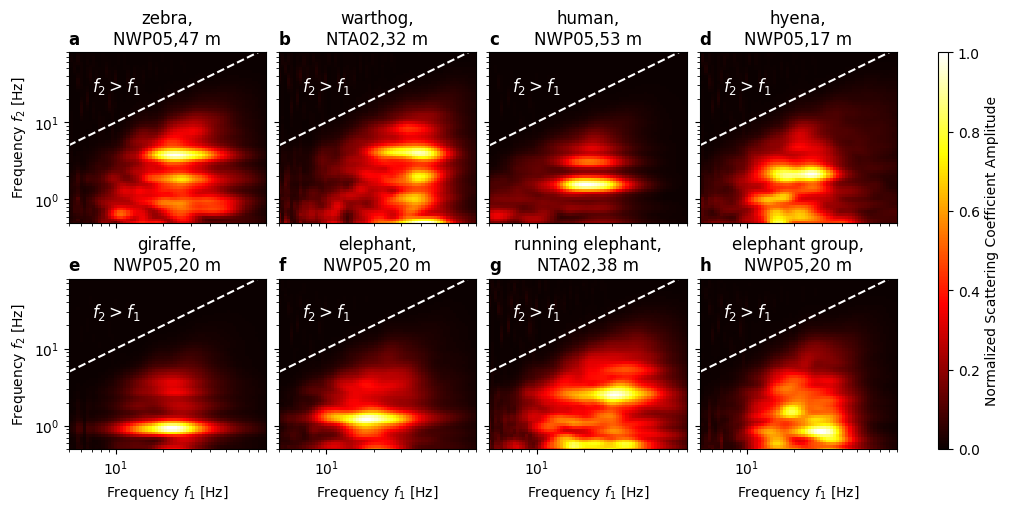

In [41]:
fig, axes = plt.subplots(2, len(indices)//2, figsize=(10, 5), sharey=True, sharex=True, constrained_layout=True)

axes[0][0].set_ylabel('Frequency $f_2$ [Hz]')
axes[1][0].set_ylabel('Frequency $f_2$ [Hz]')

axes[1][0].set_xlabel('Frequency $f_1$ [Hz]')
axes[1][1].set_xlabel('Frequency $f_1$ [Hz]')
axes[1][2].set_xlabel('Frequency $f_1$ [Hz]')
axes[1][3].set_xlabel('Frequency $f_1$ [Hz]')


axes = axes.flatten()
vmin=0
vmax=1

# plot the scattering coefficients
for i in range(n_obs):

    ax = axes[i]
    scat_coef_1_example = scat_coef_1[i]
    scat_coef_1_example /= np.max(scat_coef_1_example)
    #scat_coef_1_example = masking_matrix * scat_coef_1_example

    # plot the scattering coefficients
    img = ax.pcolormesh(wavelet_params['frequencies_0'], wavelet_params['frequencies_1'], scat_coef_1_example.T,shading='auto',cmap='hot', vmin=vmin, vmax=vmax)
    ax.plot(wavelet_params['frequencies_0'], wavelet_params['frequencies_0'], 'w--')
    ax.text(10, 30, '$f_2 > f_1$', horizontalalignment='center', verticalalignment='center', color='white', fontsize=12)
    if i == 6:
        ax.set_title('running %s,\n%s,%d m' % (species_labels[i], stations_labels[i], distances_labels[i]))
    elif i == 7:
        ax.set_title('%s group,\n%s,%d m' % (species_labels[i], stations_labels[i], distances_labels[i]))
    else:
        ax.set_title('%s,\n%s,%d m' % (species_labels[i], stations_labels[i], distances_labels[i]))

    ax.set_title(chr(97+i), loc='left', fontsize=12, fontweight='bold')
    
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim([wavelet_params['frequencies_0'][0], wavelet_params['frequencies_0'][-1]])
axes[0].set_ylim([wavelet_params['frequencies_1'][0], wavelet_params['frequencies_1'][-1]])

fig.colorbar(img, ax=axes, orientation='vertical', label='Normalized Scattering Coefficient Amplitude', pad=0.05, aspect=40)